<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_4/15_FactorAnalysis_Isomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2024 Course "Introduction to Machine Learnign in Materials Science"

Instructor Sergei V. Kalinin

Let's experiment with factor analysis. Here, the idea is to discover (linear) latent factors behind the data. Use ChatGPT to read about fatcor analysis, and how it is different with PCA.

# Factor Analysis for Image data

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Factor Loadings (10 factors, reshaped to 28x28 images):


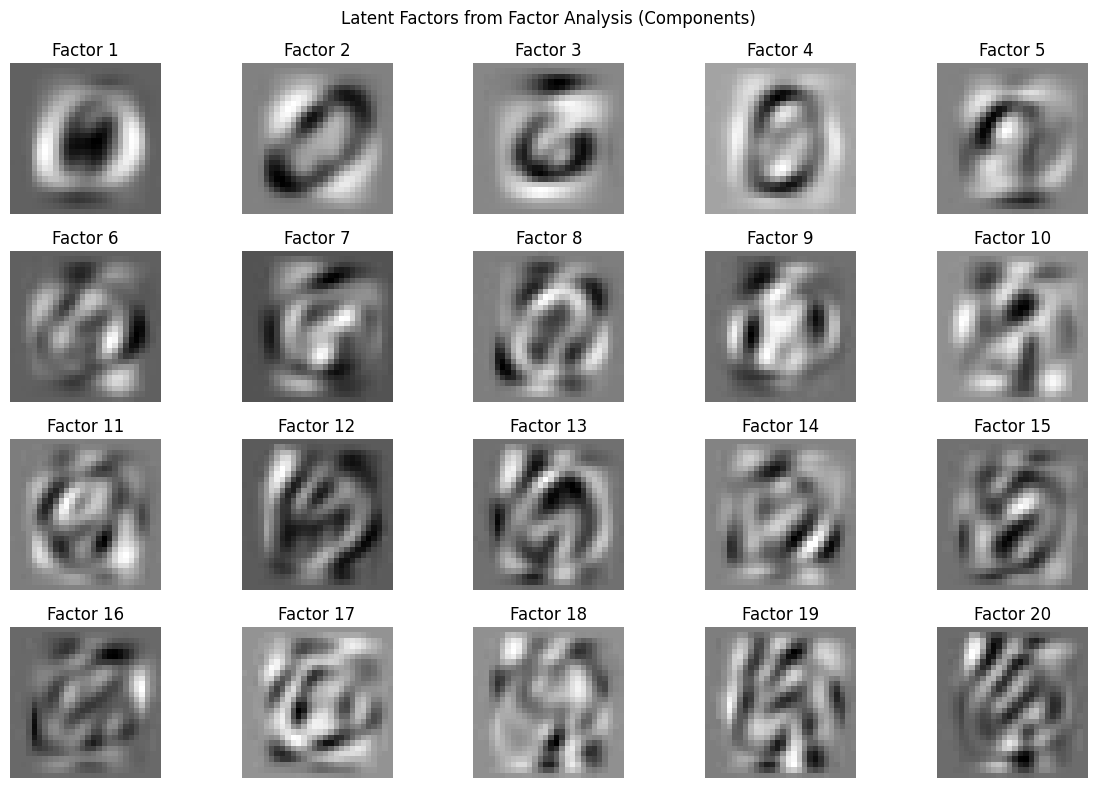


Explained Noise Variance by Each Factor:


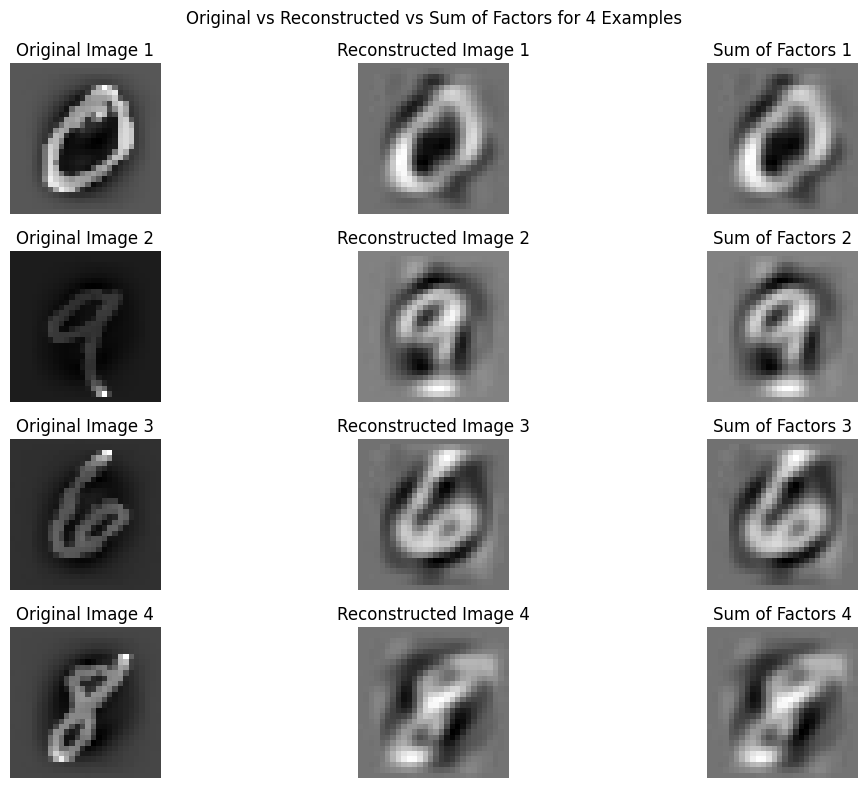


Factor Weights for Image 1:
[ 0.59929917 -1.62809573 -0.24630665 -0.60495696 -0.17957759  0.56223467
 -0.22059091  1.26188895 -1.60992577 -0.17379199 -0.26184075  0.56075018
  0.05821346  0.22382337  0.74228186  0.0588237   0.65154191 -0.19125579
 -0.52805698 -0.91629442]

Factor Weights for Image 2:
[-0.78678065  0.23813729  0.64926231  0.65988547 -1.53054522 -0.44145608
  0.59365218  0.8547906  -0.25008494 -0.89257642  0.85483011  0.21151472
  0.25084342  0.6194776   0.64949306 -0.65928805  0.38365889 -0.25106535
 -0.09036082 -1.15921898]

Factor Weights for Image 3:
[-0.550283   -0.24284516 -1.67008963 -0.04063866 -0.152887    0.18450512
  0.54977985  0.47828749  0.12281373  1.26811876 -0.11902746 -0.25893397
  0.96210386 -0.73134884  0.54603113  0.38412277  1.63277901  1.02350827
 -0.52228684 -1.53825143]

Factor Weights for Image 4:
[-0.8264126  -0.68435282  1.03808084  0.29943891  1.18087774 -0.56534725
  0.77349706  0.10575876  0.29884268  0.82780812  0.40548961 -0.27598943
 -0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# Load MNIST dataset from keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Reshape and filter data for digits 6, 9, 0, and 8
digits_of_interest = [6, 9, 0, 8]
mask = np.isin(y_train, digits_of_interest)
X_filtered = X_train[mask].reshape(-1, 28*28)
y_filtered = y_train[mask]

# Standardize the data
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Perform Factor Analysis with 10 factors
n_factors = 20
fa = FactorAnalysis(n_components=n_factors, random_state=42)
X_factors = fa.fit_transform(X_filtered_scaled)

# Show full output: Factor loadings
print("Factor Loadings (10 factors, reshaped to 28x28 images):")
plt.figure(figsize=(12, 8))
for i in range(n_factors):
    plt.subplot(4, 5, i + 1)
    plt.imshow(fa.components_[i].reshape(28, 28), cmap='gray')
    plt.title(f'Factor {i+1}')
    plt.axis('off')
plt.suptitle('Latent Factors from Factor Analysis (Components)')
plt.tight_layout()
plt.show()

# Explained variance (Noise variance in FA)
print("\nExplained Noise Variance by Each Factor:")
#print(fa.noise_variance_)

# Pick 4 examples to show how they are reconstructed by factors
example_indices = [0, 1, 2, 3]  # Select 4 examples
X_original = X_filtered_scaled[example_indices]
X_reconstructed = np.dot(X_factors[example_indices], fa.components_)

# Show original images and reconstructed as sum of factors
plt.figure(figsize=(12, 8))
for i, idx in enumerate(example_indices):
    # Plot the original image
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(X_original[i].reshape(28, 28), cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Plot the reconstructed image from factors
    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title(f'Reconstructed Image {i+1}')
    plt.axis('off')

    # Plot the weighted sum of factors
    plt.subplot(4, 3, i * 3 + 3)
    weighted_sum = sum(factor * weight for factor, weight in zip(fa.components_, X_factors[i]))
    plt.imshow(weighted_sum.reshape(28, 28), cmap='gray')
    plt.title(f'Sum of Factors {i+1}')
    plt.axis('off')

plt.suptitle('Original vs Reconstructed vs Sum of Factors for 4 Examples')
plt.tight_layout()
plt.show()

# Show individual factor weights for each of the 4 examples
for i, idx in enumerate(example_indices):
    print(f"\nFactor Weights for Image {i+1}:")
    print(X_factors[i])


Looks like for imaging data (unsurprisingly) it does not work very well. Experiment with number of factors.

# Factor Analysis for Spectral Data

In [2]:
from copy import deepcopy as dc

import numpy as np
import torch
import h5py

from scipy import ndimage
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Libraries for data processing and machine learning
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
# For image/data manipulation
from scipy.ndimage import zoom

In [3]:
!gdown https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
!gdown https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
!gdown https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
!gdown https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx

Downloading...
From: https://drive.google.com/uc?id=1uCfAKlk5KTnsgNJQiiOsjdsvBx2CMzE1
To: /content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5
100% 49.5M/49.5M [00:01<00:00, 30.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TTNNnmIS2b1HW8q7ywLbBRhUUBdTm1KU
To: /content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5
100% 19.8M/19.8M [00:00<00:00, 23.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=195ih426XxtRAlidtxzSA5nIRemP3SvML
To: /content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5
100% 19.7M/19.7M [00:00<00:00, 41.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cBfegFNV782WCIEKAn_hDA2RgtAJQkAx
To: /content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5
100% 15.4M/15.4M [00:00<00:00, 21.5MB/s]


In [4]:
h5_f1 = h5py.File(r'/content/20220510_D17_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_3g_corrected.h5', 'r+')
h5_f2 = h5py.File(r'/content/0220415_D45_30kx_5kV_32pA_LV_200ms_119X80_40nm_1_corrected.h5', 'r+')
h5_f3 = h5py.File(r'/content/0220415_D48_30kx_5kV_32pA_LV_400ms_119X80_40nm_2_corrected.h5', 'r+')
h5_f4 = h5py.File(r'/content/0220418_D50_30kx_5kV_32pA_LV_400ms_119X80_40nm_1MHz_8g_re_corrected.h5', 'r+')

(1024, 1, 1, 80, 119)


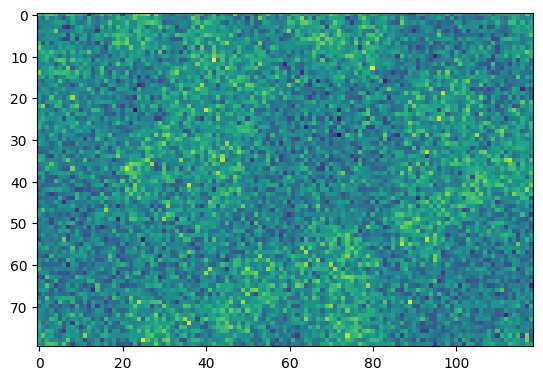

In [5]:
print(h5_f4['Acquisition2']['ImageData']['Image'].shape)
im2 = np.squeeze(h5_f4['Acquisition2']['ImageData']['Image'])
plt.imshow(im2[200,:,:])

In [6]:
dataset = im2.astype(np.float64)
print(dataset.shape)
d1, d2, d3 = dataset.shape
dataset = dataset.reshape(d1, d2*d3)

(1024, 80, 119)


In [7]:
y = torch.from_numpy(np.array(dataset.T))[:, None]
y = torch.nn.functional.avg_pool1d(y, 1, 1).squeeze().numpy()
print(y.shape)
_, s1 = y.shape

(9520, 1024)


In [8]:
y = y.reshape(d2, d3, s1)

In [9]:
hdata = y
hdata = hdata.astype(np.float64)

In [10]:
x=np.linspace(162.17, 1033.31, 1024) #128
wavelength = x

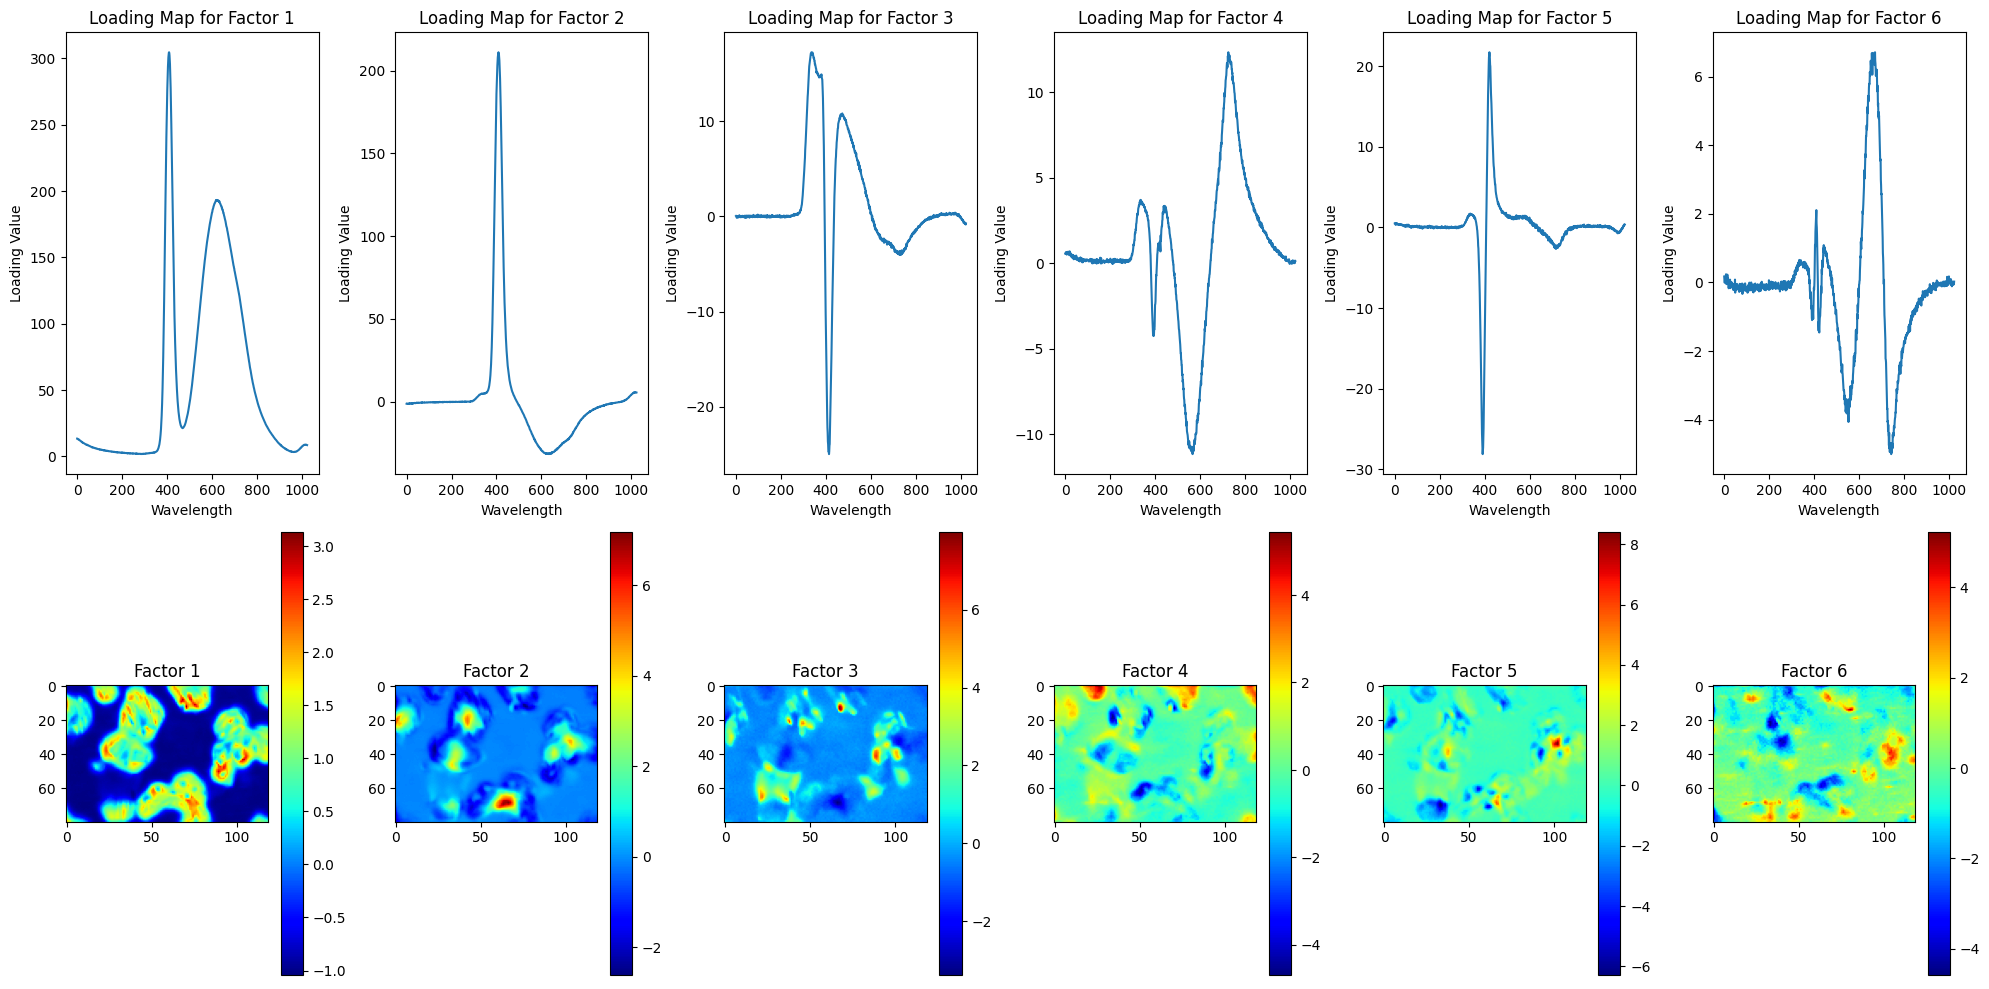

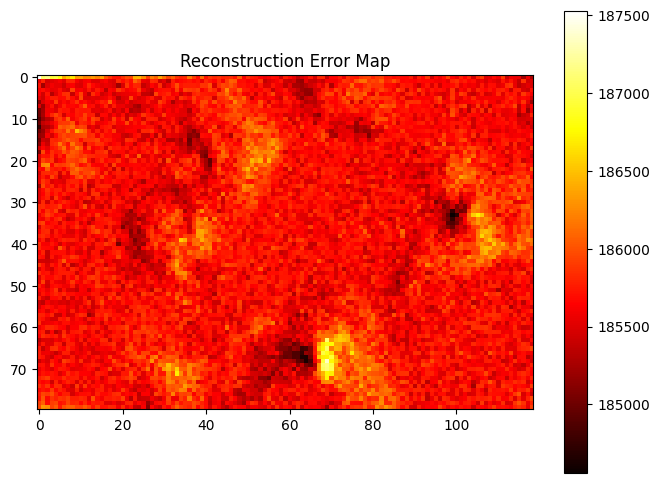

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# Assuming hdata has the shape (h, w, spectra_size) where h = height, w = width, and spectra_size = number of spectral features
h, w, spectra_size = hdata.shape

# Reshape the data so that each point (pixel) is represented by its spectrum (spectra_all_points is now 2D)
spectra_all_points = hdata.reshape(-1, spectra_size)

# Standardize the data
scaler = StandardScaler()
spectra_all_points_scaled = spectra_all_points #scaler.fit_transform(spectra_all_points)

# Perform Factor Analysis
n_factors = 6  # Number of factors to extract
fa = FactorAnalysis(n_components=n_factors, random_state=42)
factors = fa.fit_transform(spectra_all_points_scaled)
loadings = fa.components_

# Reshape factors for visualization
factors_image = factors.reshape(h, w, n_factors)

# Plot loading maps and factors
fig, ax = plt.subplots(2, n_factors, figsize=(20, 10))

# Plot loading maps (spectral loading vectors for each factor)
wavelength = np.arange(spectra_size)  # Placeholder for wavelength axis, replace with actual wavelengths if available
for i in range(n_factors):
    ax[0, i].plot(wavelength, loadings[i, :])
    ax[0, i].set_title(f'Loading Map for Factor {i+1}')
    ax[0, i].set_xlabel('Wavelength')
    ax[0, i].set_ylabel('Loading Value')

# Plot factor images (spatial distribution of factors)
for i in range(n_factors):
    im = ax[1, i].imshow(factors_image[:, :, i], cmap='jet', origin='upper')
    ax[1, i].set_title(f'Factor {i+1}')
    fig.colorbar(im, ax=ax[1, i])

plt.tight_layout()
plt.show()

# Calculate the reconstruction error
# Reconstruct the data by multiplying factors by the loadings and adding back the mean
reconstructed_data = np.dot(factors, loadings)

# Reverse the scaling
reconstructed_data = reconstructed_data #scaler.inverse_transform(reconstructed_data)

# Reshape the reconstructed data to its original shape (h, w, spectra_size)
reconstructed_data_image = reconstructed_data.reshape(h, w, spectra_size)

# Calculate the reconstruction error (mean squared error for each pixel/spectra point)
reconstruction_error = np.mean((spectra_all_points - reconstructed_data) ** 2, axis=1)
reconstruction_error_image = reconstruction_error.reshape(h, w)

# Plot the reconstruction error map
plt.figure(figsize=(8, 6))
plt.imshow(reconstruction_error_image, cmap='hot', origin='upper')
plt.title('Reconstruction Error Map')
plt.colorbar()
plt.show()

# Comparison of different linear decompositions

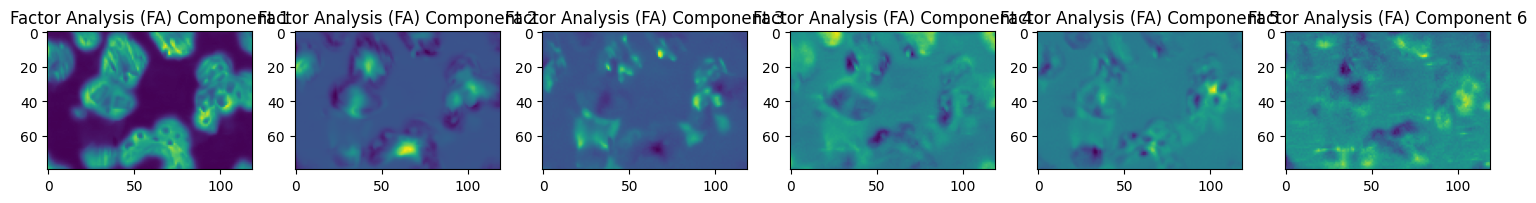

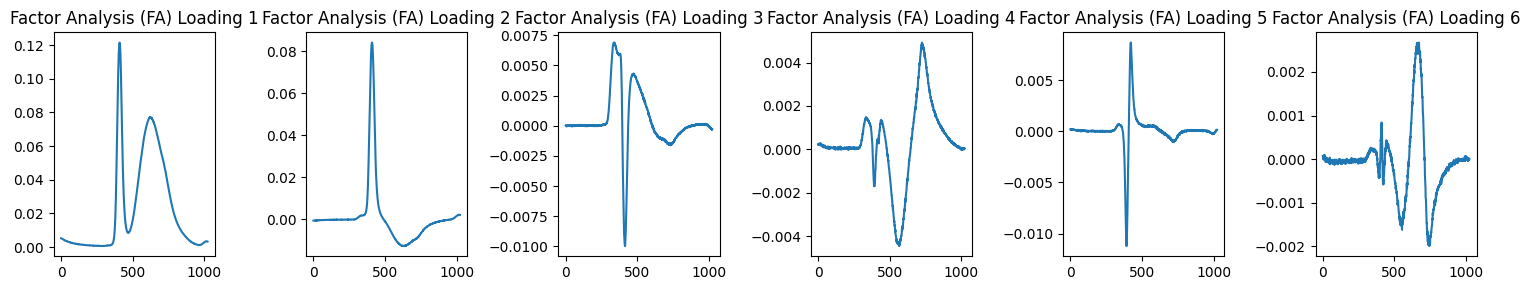

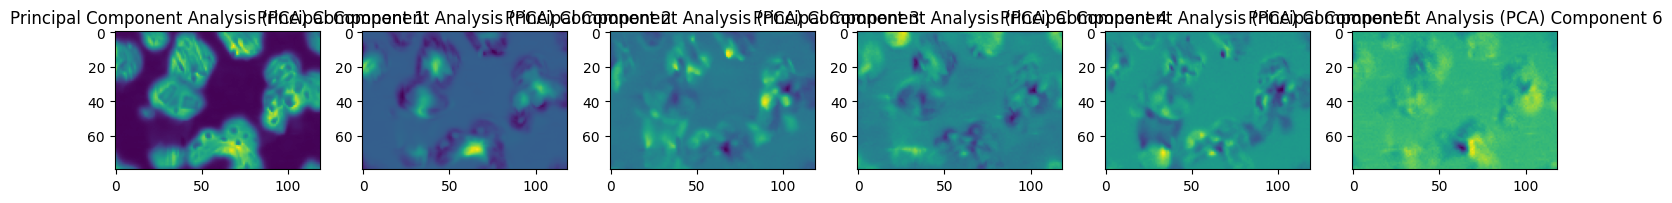

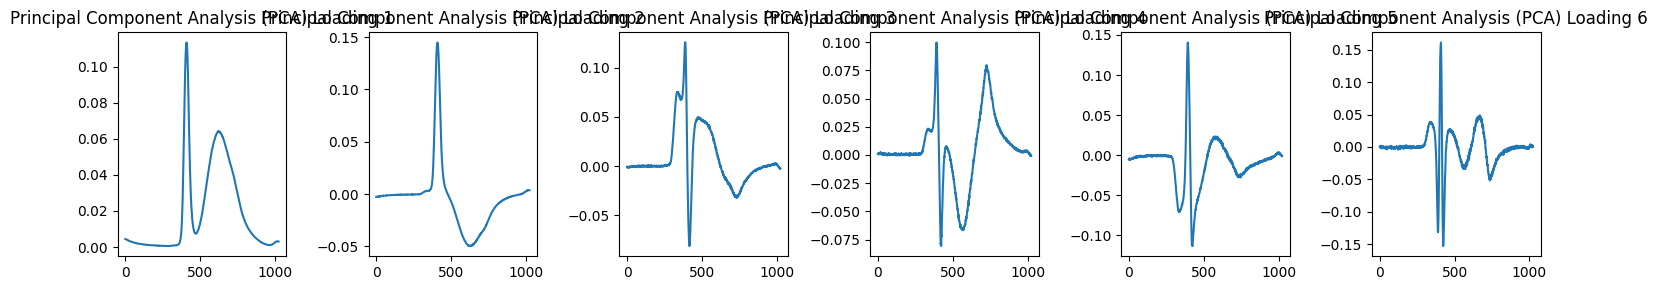

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


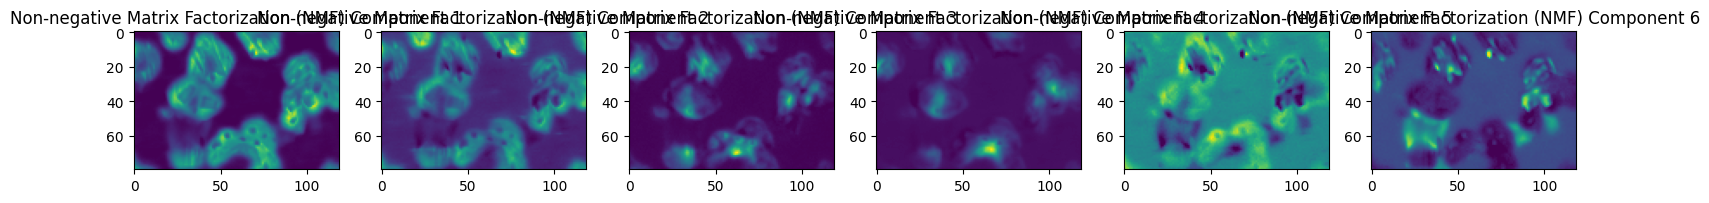

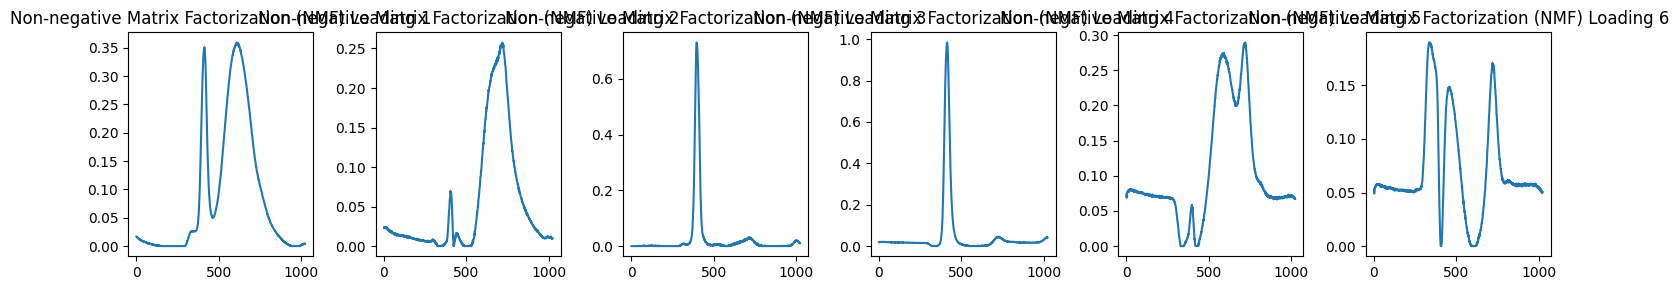

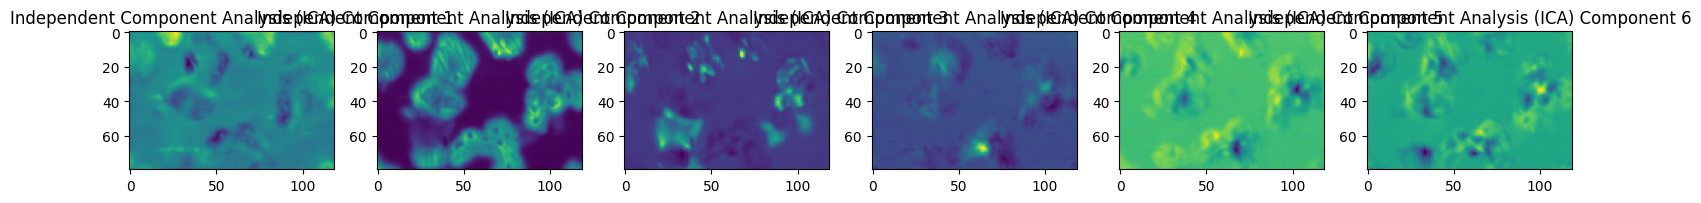

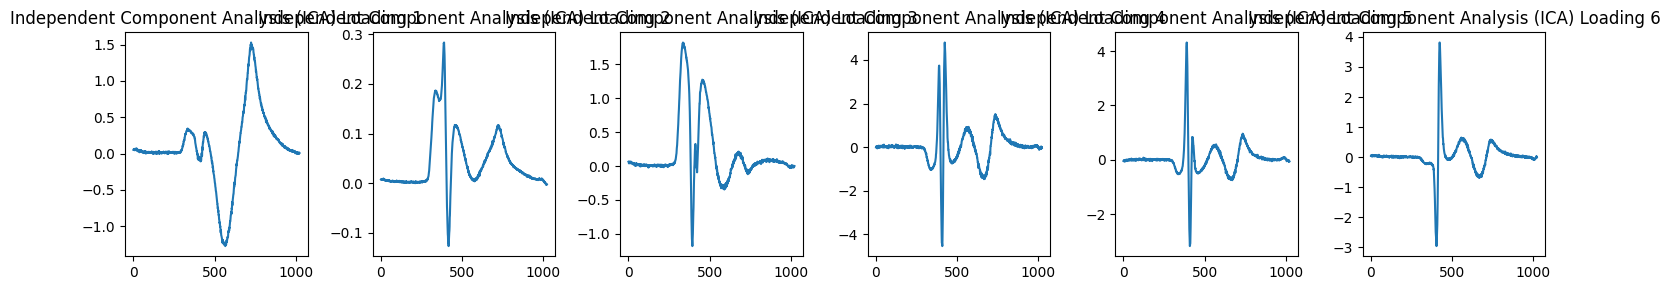

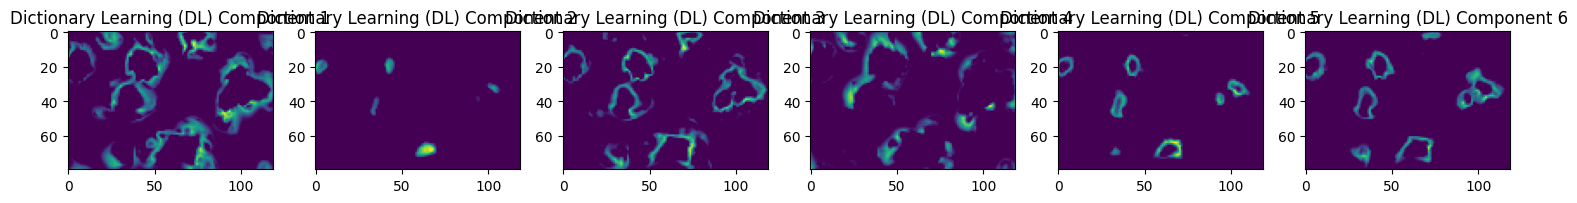

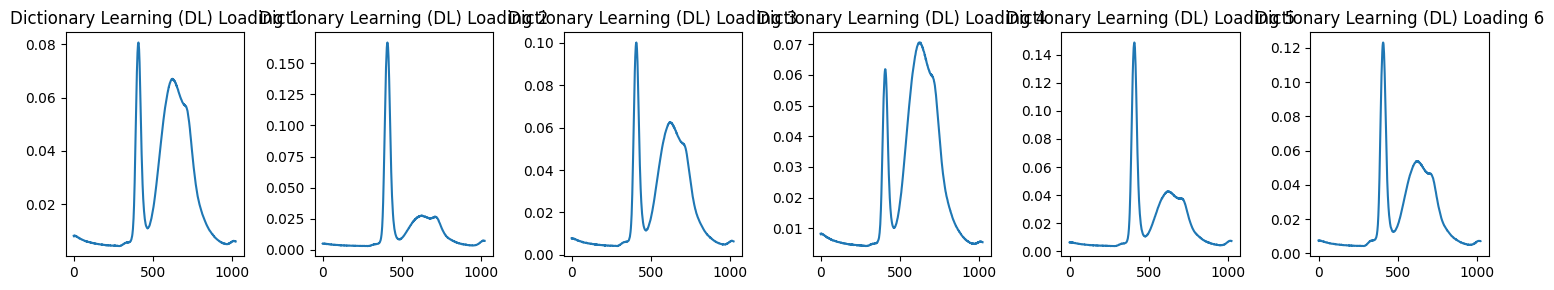

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis, PCA, NMF, FastICA, DictionaryLearning
from sklearn.preprocessing import StandardScaler

# Assuming hdata has the shape (h, w, spectra_size) where h = height, w = width, and spectra_size = number of spectral features
h, w, spectra_size = hdata.shape

# Reshape the data so that each point (pixel) is represented by its spectrum (spectra_all_points is now 2D)
spectra_all_points = hdata.reshape(-1, spectra_size)

'''
# Standardize the data (optional depending on the method)
scaler = StandardScaler()
spectra_all_points_scaled = scaler.fit_transform(spectra_all_points)
'''

spectra_all_points_scaled = (spectra_all_points - np.min(spectra_all_points)) / np.ptp(spectra_all_points)

# Number of components (factors)
n_factors = 6

# Function to plot loadings and components
def plot_results(components, loadings, method_name):
    # Reshape components for visualization
    components_image = components.reshape(h, w, n_factors)

    # Plot the loading maps (components)
    fig, axes = plt.subplots(1, n_factors, figsize=(15, 3))
    for i in range(n_factors):
        axes[i].imshow(components_image[:, :, i], cmap='viridis')
        axes[i].set_title(f'{method_name} Component {i+1}')
    plt.tight_layout()
    plt.show()

    # Plot the loadings (factors)
    fig, axes = plt.subplots(1, n_factors, figsize=(15, 3))
    for i in range(n_factors):
        axes[i].plot(loadings[i, :])
        axes[i].set_title(f'{method_name} Loading {i+1}')
    plt.tight_layout()
    plt.show()

# Perform Factor Analysis (FA)
fa = FactorAnalysis(n_components=n_factors, random_state=42)
factors_fa = fa.fit_transform(spectra_all_points_scaled)
loadings_fa = fa.components_
plot_results(factors_fa, loadings_fa, 'Factor Analysis (FA)')

# Perform Principal Component Analysis (PCA)
pca = PCA(n_components=n_factors, random_state=42)
factors_pca = pca.fit_transform(spectra_all_points_scaled)
loadings_pca = pca.components_
plot_results(factors_pca, loadings_pca, 'Principal Component Analysis (PCA)')

# Perform Non-negative Matrix Factorization (NMF)
nmf = NMF(n_components=n_factors, random_state=42, init='random', max_iter=500)
factors_nmf = nmf.fit_transform(spectra_all_points_scaled)
loadings_nmf = nmf.components_
plot_results(factors_nmf, loadings_nmf, 'Non-negative Matrix Factorization (NMF)')

# Perform Independent Component Analysis (ICA)
ica = FastICA(n_components=n_factors, random_state=42, max_iter=500)
factors_ica = ica.fit_transform(spectra_all_points_scaled)
loadings_ica = ica.components_
plot_results(factors_ica, loadings_ica, 'Independent Component Analysis (ICA)')

# Perform Dictionary Learning (DL)
dl = DictionaryLearning(n_components=n_factors, random_state=42, max_iter=500)
factors_dl = dl.fit_transform(spectra_all_points_scaled)
loadings_dl = dl.components_
plot_results(factors_dl, loadings_dl, 'Dictionary Learning (DL)')


# Isomap Demo

Let's play with Isomap on simple data

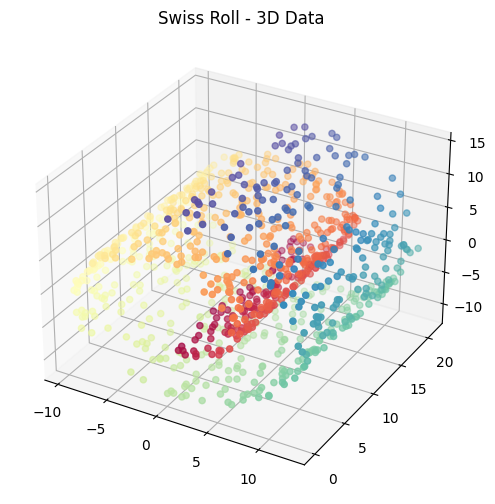

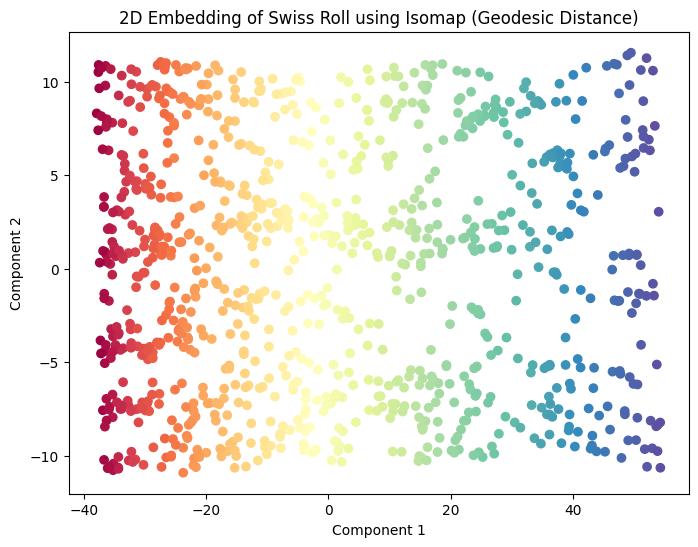

Geodesic distance matrix (first 5 points):
 [[ 0.         30.30952815 58.08871325 38.72457007 28.13793419]
 [30.30952815  0.         87.2753343  67.1591832  57.32455523]
 [58.08871325 87.2753343   0.         21.38906567 32.04861163]
 [38.72457007 67.1591832  21.38906567  0.         14.85486375]
 [28.13793419 57.32455523 32.04861163 14.85486375  0.        ]]


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.datasets import make_swiss_roll

# Generate synthetic data: Swiss roll
n_samples = 1000
X, color = make_swiss_roll(n_samples, noise=0.1)

# Visualize the Swiss roll in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Swiss Roll - 3D Data")
plt.show()

# Compute the geodesic distances using Isomap
n_neighbors = 10  # Number of neighbors to use for graph construction
n_components = 2   # Number of dimensions to project onto

isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
X_isomap = isomap.fit_transform(X)

# Visualize the 2D embedding of the Swiss roll
plt.figure(figsize=(8, 6))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("2D Embedding of Swiss Roll using Isomap (Geodesic Distance)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Compute the geodesic distance matrix
geodesic_distances = isomap.dist_matrix_

# Print the geodesic distance matrix for the first 5 points
print("Geodesic distance matrix (first 5 points):\n", geodesic_distances[:5, :5])


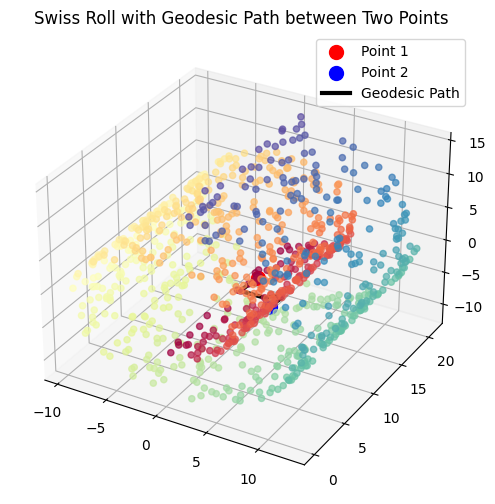

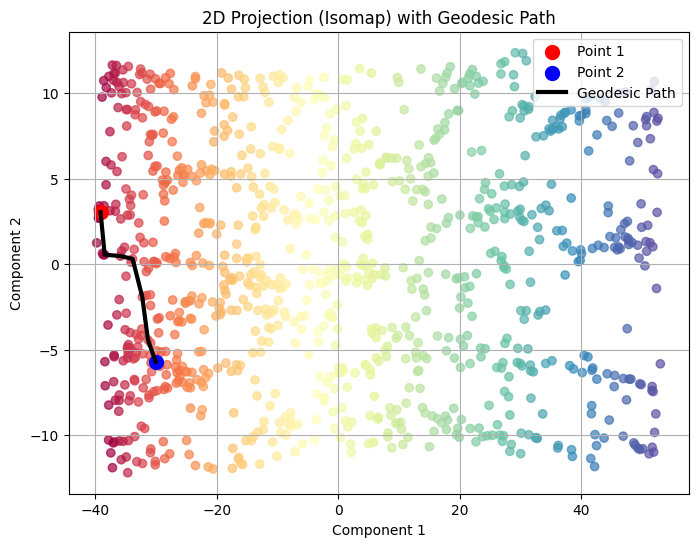

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import kneighbors_graph
import networkx as nx

# Generate synthetic data: Swiss roll
n_samples = 1000
X, color = make_swiss_roll(n_samples, noise=0.1)

# Compute the geodesic distances using Isomap
n_neighbors = 10  # Number of neighbors to use for graph construction
isomap = Isomap(n_neighbors=n_neighbors, n_components=2)
X_isomap = isomap.fit_transform(X)

# Select two arbitrary points from the dataset
point1 = 0
point2 = 150

# Create the nearest neighbors graph used by Isomap
knn_graph = kneighbors_graph(X, n_neighbors=n_neighbors, mode='distance')

# Convert the nearest neighbors graph to a NetworkX graph
G = nx.from_scipy_sparse_array(knn_graph)

# Use Dijkstra's algorithm to find the shortest path between point1 and point2
shortest_path = nx.shortest_path(G, source=point1, target=point2)

# Get the coordinates of the points in the shortest path
path_coords = X[shortest_path]
path_coords_2d = X_isomap[shortest_path]

# Plot the original Swiss roll in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral, alpha=0.7)

# Highlight the two selected points
ax.scatter(X[point1, 0], X[point1, 1], X[point1, 2], color='red', s=100, label='Point 1')
ax.scatter(X[point2, 0], X[point2, 1], X[point2, 2], color='blue', s=100, label='Point 2')

# Plot the geodesic path between the two points
ax.plot(path_coords[:, 0], path_coords[:, 1], path_coords[:, 2], color='black', linewidth=3, label='Geodesic Path')

# Set titles and legends
ax.set_title("Swiss Roll with Geodesic Path between Two Points")
ax.legend()

plt.show()

# Plot the 2D projection (Isomap) with the geodesic path
plt.figure(figsize=(8, 6))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=color, cmap=plt.cm.Spectral, alpha=0.7)

# Highlight the two selected points in 2D
plt.scatter(X_isomap[point1, 0], X_isomap[point1, 1], color='red', s=100, label='Point 1')
plt.scatter(X_isomap[point2, 0], X_isomap[point2, 1], color='blue', s=100, label='Point 2')

# Plot the geodesic path in 2D
plt.plot(path_coords_2d[:, 0], path_coords_2d[:, 1], color='black', linewidth=3, label='Geodesic Path')

# Set titles and legends
plt.title("2D Projection (Isomap) with Geodesic Path")
plt.legend()
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()
